# Input Data, Variables, and Parameters

In [34]:
import numpy as np
import os
import pandas as pd
import arcpy

# Import the required ArcGIS API for Python modules
import arcgis
from arcgis.gis import GIS
gis = arcgis.GIS()
from arcgis.geoanalytics import manage_data

from IPython.display import display, Markdown

In [35]:
dirWork         = os.getcwd()
dirInput        = os.path.join(dirWork, r'input'         )
dirIntermediate = os.path.join(dirWork, r'intermediate'  )
dirResults      = os.path.join(dirWork, r'results'       )
dirParams       = os.path.join(dirWork, r'params'        )
dirWebApp       = os.path.join(dirResults, r'webapp_data')

sStationCol     = 'STATION'
sDayCol         = 'DAY'
sDOWCol         = 'DOW'
sMonthCol       = 'MONTH'
sYearCol        = 'YEAR'
sYearGrpCol     = 'YEARGROUP'
sSeasonGrpCol   = 'SEASONGROUP'
sMonthADTCol    = 'MONTHADT'
sMonthDOWADTCol = 'MONTHDOWADT'
sYearADTCol     = 'YEARADT'
sStationGrpCol  = 'STATIONGROUP'
sDOWGrpCol      = 'DOWGROUP'
sDOWFieldName   = 'DOWFLDNM'
sSGFieldName    = 'SGFLDNM'


In [36]:
#read parameter tables
#csv: , parse_dates=['DATEFROM','DATETO']
prmDOWToDayGroups         = pd.read_csv(os.path.join(dirParams, r'dow_to_dow_groups.csv'              ))
prmMonthToSeasonGroups    = pd.read_csv(os.path.join(dirParams, r'month_to_season_groups.csv'         ))
prmYearToYearGroups       = pd.read_csv(os.path.join(dirParams, r'year_to_year_groups.csv'            ))
prmYearGroups             = pd.read_csv(os.path.join(dirParams, r'year_groups.csv'                    ))
prmStationToStationGroups = pd.read_csv(os.path.join(dirParams, r'station_to_station_groups.csv'      ))
prmStationGroups          = pd.read_csv(os.path.join(dirParams, r'station_groups.csv'                 ))
prmDOWFactorsMaxMin       = pd.read_csv(os.path.join(dirParams, r'dow_factors_maxmin.csv'             ))

prmFieldNamesSeasonGroup  = pd.read_csv(os.path.join(dirParams, r'season_group_field_names.csv'       ))
prmFieldNamesDOWGroup     = pd.read_csv(os.path.join(dirParams, r'dow_group_field_names.csv'          ))
 
prmWebAppDOWGroups        = pd.read_csv(os.path.join(dirParams, r'dow_webapp.csv'                     ))
prmWebAppSeasonGroups     = pd.read_csv(os.path.join(dirParams, r'season_webapp.csv'                  ))
 
prmDerivedStationPortions = pd.read_csv(os.path.join(dirParams, r'station_groups_derived_portions.csv'))

In [37]:
#read processed data
dfMonthADT          = pd.read_csv(os.path.join(dirIntermediate, r'MonthADT.csv'))
dfMonthDOWADT       = pd.read_csv(os.path.join(dirIntermediate, r'MonthDOWADT.csv'))
dfYearADT           = pd.read_csv(os.path.join(dirIntermediate, r'YearADT.csv'))
dfDayVol            = pd.read_csv(os.path.join(dirIntermediate, r'DayVol.csv'))
dfDayPeriodVol      = pd.read_csv(os.path.join(dirIntermediate, r'DayPeriodVol.csv'))
dfMonthDOWPeriodVol = pd.read_csv(os.path.join(dirIntermediate, r'MonthDOWPeriodVol.csv'))

In [38]:
#processed outputs
csv_factors        = os.path.join(dirIntermediate,'CCS_Factors_AllGroupings.csv'       )
csv_factors_period = os.path.join(dirIntermediate,'CCS_Factors_Period_AllGroupings.csv')

In [39]:
#json outputs
json_dowfactors             = os.path.join(dirWebApp, r'dowfactors.json'            )
json_stationgroups          = os.path.join(dirWebApp, r'stationgroups.json'         )
json_stationgroups_finalcut = os.path.join(dirWebApp, r'stationgroups_finalcut.json')
#json_stationgroups_ccs     = os.path.join(dirWebApp, r'stationgroups_ccs.json'     )
json_wdfactors              = os.path.join(dirWebApp, r'wdfactors.json'             )
json_yeargroups             = os.path.join(dirWebApp, r'yeargroups.json'            )
json_monthfactors           = os.path.join(dirWebApp, r'monthfactors.json'          )
json_seasonfactors          = os.path.join(dirWebApp, r'seasonfactors.json'         )

# Year/Season Group ADTs

In [40]:
#calculate year adt for each grouping
dfYearGroupADTs = pd.DataFrame.merge(dfYearADT,prmYearToYearGroups,on=(sYearCol))
dfYearGroupADTs = pd.DataFrame.merge(dfYearGroupADTs,prmStationToStationGroups,on=(sStationCol))
dfYearGroupADTs = dfYearGroupADTs.groupby([sStationGrpCol,sYearGrpCol],as_index=False).agg(AVGYEARADT=(sYearADTCol,'mean'))
dfYearGroupADTs

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
display(dfYearGroupADTs)
pd.set_option('display.max_rows', 10)

,STATIONGROUP,YEARGROUP,AVGYEARADT
0,301,2013,49525.395238
1,301,2013-2017,54698.437659
2,301,2014,51804.412302
3,301,2015,54572.420833
4,301,2015-2019,57627.999504
5,301,2016,59236.130952
6,301,2017,58353.828968
7,301,2018,58349.617262
8,301,2019-2023,57393.518353
9,301,2020,52054.829365


# Season Factors

In [41]:
#calculate month adt for each grouping
dfSeasonGroupADTs = pd.DataFrame.merge(dfMonthADT,prmMonthToSeasonGroups,on=(sMonthCol))
dfSeasonGroupADTs = pd.DataFrame.merge(dfSeasonGroupADTs,prmYearToYearGroups,on=(sYearCol))
dfSeasonGroupADTs = pd.DataFrame.merge(dfSeasonGroupADTs,prmStationToStationGroups,on=(sStationCol))
dfSeasonGroupADTs = dfSeasonGroupADTs.groupby([sStationGrpCol,sSeasonGrpCol,sYearGrpCol],as_index=False).agg(AVGSEASONADT=(sMonthADTCol,'mean'))
dfSeasonGroupADTs

,STATIONGROUP,SEASONGROUP,YEARGROUP,AVGSEASONADT
0,301,M01-Jan,2013,44843.840476
1,301,M01-Jan,2013-2017,52119.840476
2,301,M01-Jan,2014,51059.159524
3,301,M01-Jan,2015,51268.092857
4,301,M01-Jan,2015-2019,55225.066071
...,...,...,...,...
43430,WDK,Year,2016,23810.038690
43431,WDK,Year,2018,25320.111706
43432,WDK,Year,2019,25975.874405
43433,WDK,Year,2019-2023,25975.874405


In [42]:
dfSeasonFactors = pd.DataFrame.merge(dfSeasonGroupADTs,dfYearGroupADTs,on=(sStationGrpCol,sYearGrpCol))
dfSeasonFactors['SEASONFACTOR'] = dfSeasonFactors['AVGSEASONADT'] / dfSeasonFactors['AVGYEARADT'] 
dfSeasonFactors

,STATIONGROUP,SEASONGROUP,YEARGROUP,AVGSEASONADT,AVGYEARADT,SEASONFACTOR
0,301,M01-Jan,2013,44843.840476,49525.395238,0.905472
1,301,M02-Feb,2013,45251.178571,49525.395238,0.913696
2,301,M03-Mar,2013,46548.835714,49525.395238,0.939898
3,301,M04-Apr,2013,42423.921429,49525.395238,0.856609
4,301,M05-May,2013,43828.209524,49525.395238,0.884964
...,...,...,...,...,...,...
43430,WDK,S01-Winter,All Years,21859.765397,23764.601667,0.919846
43431,WDK,S02-Spring,All Years,22015.717937,23764.601667,0.926408
43432,WDK,S03-Summer,All Years,27620.208413,23764.601667,1.162242
43433,WDK,S04-Fall,All Years,23562.714921,23764.601667,0.991505


In [43]:
#get field names
dfSeasonFactors = pd.DataFrame.merge(dfSeasonFactors, prmFieldNamesSeasonGroup, on=sSeasonGrpCol)
dfSeasonFactors = dfSeasonFactors.rename(columns={sSGFieldName:'FACTORNAME','SEASONFACTOR':'FACTOR'})
dfSeasonFactors = dfSeasonFactors[[sStationGrpCol,sSeasonGrpCol,sYearGrpCol,'FACTORNAME','FACTOR']]
dfSeasonFactors

,STATIONGROUP,SEASONGROUP,YEARGROUP,FACTORNAME,FACTOR
0,301,M01-Jan,2013,FAC_JAN,0.905472
1,301,M01-Jan,2013-2017,FAC_JAN,0.952858
2,301,M01-Jan,2014,FAC_JAN,0.985614
3,301,M01-Jan,2015,FAC_JAN,0.939451
4,301,M01-Jan,2015-2019,FAC_JAN,0.958303
...,...,...,...,...,...
43430,WDK,Year,2016,FAC_YR,1.000000
43431,WDK,Year,2018,FAC_YR,1.000000
43432,WDK,Year,2019,FAC_YR,1.000000
43433,WDK,Year,2019-2023,FAC_YR,1.000000


# Max Month Factor

In [44]:
prmMonthToSeasonGroups_justMonths = prmMonthToSeasonGroups[prmMonthToSeasonGroups['SGTYPE']=='Month']
prmMonthToSeasonGroups_justMonths

,MONTH,SEASONGROUP,SGTYPE
0,1,M01-Jan,Month
1,2,M02-Feb,Month
2,3,M03-Mar,Month
3,4,M04-Apr,Month
4,5,M05-May,Month
...,...,...,...
7,8,M08-Aug,Month
8,9,M09-Sep,Month
9,10,M10-Oct,Month
10,11,M11-Nov,Month


In [45]:
dfMaxMonthFactor = pd.DataFrame.merge(dfSeasonFactors,prmMonthToSeasonGroups_justMonths,on=sSeasonGrpCol)
dfMaxMonthFactorMax = dfMaxMonthFactor.groupby([sStationGrpCol,sYearGrpCol],as_index=False).agg(FAC_MAX=('FACTOR','max'))
dfMaxMonthFactorMax['FACTORNAME']='FAC_MAX'
dfMaxMonthFactorMax[sSeasonGrpCol]='Year'
dfMaxMonthFactorMax = dfMaxMonthFactorMax.rename(columns={'FAC_MAX':'FACTOR'})
dfMaxMonthFactorMax = dfMaxMonthFactorMax[[sStationGrpCol,sSeasonGrpCol,sYearGrpCol,'FACTORNAME','FACTOR']]
dfMaxMonthFactorMax

,STATIONGROUP,SEASONGROUP,YEARGROUP,FACTORNAME,FACTOR
0,301,Year,2013,FAC_MAX,1.247890
1,301,Year,2013-2017,FAC_MAX,1.185596
2,301,Year,2014,FAC_MAX,1.162994
3,301,Year,2015,FAC_MAX,1.184390
4,301,Year,2015-2019,FAC_MAX,1.180784
...,...,...,...,...,...
2550,WDK,Year,2016,FAC_MAX,1.165954
2551,WDK,Year,2018,FAC_MAX,1.183243
2552,WDK,Year,2019,FAC_MAX,1.216987
2553,WDK,Year,2019-2023,FAC_MAX,1.216987


In [46]:
dfMaxMonthFactorMo = pd.DataFrame.merge(dfSeasonFactors,dfMaxMonthFactorMax,left_on=(sStationGrpCol,sYearGrpCol,'FACTOR'),right_on=(sStationGrpCol,sYearGrpCol,'FACTOR'))
dfMaxMonthFactorMo = pd.DataFrame.merge(dfMaxMonthFactorMo,prmMonthToSeasonGroups_justMonths,left_on=(sSeasonGrpCol+'_x'),right_on=(sSeasonGrpCol))
dfMaxMonthFactorMo = dfMaxMonthFactorMo[[sStationGrpCol,sYearGrpCol,'MONTH']]
dfMaxMonthFactorMo = dfMaxMonthFactorMo.rename(columns={'MONTH':'FACTOR'})
dfMaxMonthFactorMo[sSeasonGrpCol] = 'Year'
dfMaxMonthFactorMo['FACTORNAME'] = 'FAC_MAXMO'
dfMaxMonthFactorMo = dfMaxMonthFactorMo[[sStationGrpCol,sSeasonGrpCol,sYearGrpCol,'FACTORNAME','FACTOR']]
dfMaxMonthFactorMo


,STATIONGROUP,SEASONGROUP,YEARGROUP,FACTORNAME,FACTOR
0,317,Year,2019,FAC_MAXMO,1
1,317,Year,2019-2023,FAC_MAXMO,1
2,317,Year,2020,FAC_MAXMO,1
3,322,Year,2023,FAC_MAXMO,1
4,605,Year,2013,FAC_MAXMO,1
...,...,...,...,...,...
2550,704,Year,All Years,FAC_MAXMO,12
2551,COV,Year,2018,FAC_MAXMO,12
2552,SNV,Year,2018,FAC_MAXMO,12
2553,U70,Year,2018,FAC_MAXMO,12


# DOW Factors

In [47]:
dfMonthDOWGroupADTs = pd.DataFrame.merge(dfMonthDOWADT,prmDOWToDayGroups,on=(sDOWCol))
dfMonthDOWGroupADTs = dfMonthDOWGroupADTs.groupby([sStationCol,sYearCol,sMonthCol,sDOWGrpCol],as_index=False).agg(MONTHDOWGROUPADT=(sMonthDOWADTCol,'mean'))
dfMonthDOWGroupADTs

,STATION,YEAR,MONTH,DOWGROUP,MONTHDOWGROUPADT
0,301.0,2013,1,1-Weekday (Tu-Th),46516.600000
1,301.0,2013,1,2-Weekend (Sa-Su),42694.000000
2,301.0,2013,1,D1-Monday,41221.333333
3,301.0,2013,1,D2-Tuesday,44297.000000
4,301.0,2013,1,D3-Wednesday,47701.400000
...,...,...,...,...,...
91147,733.0,2023,12,D3-Wednesday,30356.500000
91148,733.0,2023,12,D4-Thursday,33436.250000
91149,733.0,2023,12,D5-Friday,35451.000000
91150,733.0,2023,12,D6-Saturday,31983.000000


In [48]:
#calculate month adt for each grouping
dfSeasonGroupDOWADTs = pd.DataFrame.merge(dfMonthDOWGroupADTs,prmMonthToSeasonGroups,on=(sMonthCol))
dfSeasonGroupDOWADTs = pd.DataFrame.merge(dfSeasonGroupDOWADTs,prmYearToYearGroups,on=(sYearCol))
dfSeasonGroupDOWADTs = pd.DataFrame.merge(dfSeasonGroupDOWADTs,prmStationToStationGroups,on=(sStationCol))
dfSeasonGroupDOWADTs = dfSeasonGroupDOWADTs.groupby([sStationGrpCol,sSeasonGrpCol,sYearGrpCol,sDOWGrpCol],as_index=False).agg(AVGMONTHDOWADT=('MONTHDOWGROUPADT','mean'))
dfSeasonGroupDOWADTs

,STATIONGROUP,SEASONGROUP,YEARGROUP,DOWGROUP,AVGMONTHDOWADT
0,301,M01-Jan,2013,1-Weekday (Tu-Th),46516.600000
1,301,M01-Jan,2013,2-Weekend (Sa-Su),42694.000000
2,301,M01-Jan,2013,D1-Monday,41221.333333
3,301,M01-Jan,2013,D2-Tuesday,44297.000000
4,301,M01-Jan,2013,D3-Wednesday,47701.400000
...,...,...,...,...,...
390910,WDK,Year,All Years,D3-Wednesday,24058.063611
390911,WDK,Year,All Years,D4-Thursday,25027.441111
390912,WDK,Year,All Years,D5-Friday,27784.625556
390913,WDK,Year,All Years,D6-Saturday,24347.585278


In [49]:
dfSeasonGroupDOWFactors = pd.DataFrame.merge(dfSeasonGroupDOWADTs,dfSeasonGroupADTs,on=(sStationGrpCol,sSeasonGrpCol,sYearGrpCol))
dfSeasonGroupDOWFactors['DOWFACTOR'] = dfSeasonGroupDOWFactors['AVGMONTHDOWADT'] / dfSeasonGroupDOWFactors['AVGSEASONADT']
dfSeasonGroupDOWFactors

,STATIONGROUP,SEASONGROUP,YEARGROUP,DOWGROUP,AVGMONTHDOWADT,AVGSEASONADT,DOWFACTOR
0,301,M01-Jan,2013,1-Weekday (Tu-Th),46516.600000,44843.840476,1.037302
1,301,M01-Jan,2013,2-Weekend (Sa-Su),42694.000000,44843.840476,0.952059
2,301,M01-Jan,2013,D1-Monday,41221.333333,44843.840476,0.919220
3,301,M01-Jan,2013,D2-Tuesday,44297.000000,44843.840476,0.987806
4,301,M01-Jan,2013,D3-Wednesday,47701.400000,44843.840476,1.063722
...,...,...,...,...,...,...,...
390910,WDK,Year,All Years,D3-Wednesday,24058.063611,23764.601667,1.012349
390911,WDK,Year,All Years,D4-Thursday,25027.441111,23764.601667,1.053140
390912,WDK,Year,All Years,D5-Friday,27784.625556,23764.601667,1.169160
390913,WDK,Year,All Years,D6-Saturday,24347.585278,23764.601667,1.024532


In [50]:
dfSeasonGroupDOWFactors_toCombine = pd.DataFrame.merge(dfSeasonGroupDOWFactors,prmFieldNamesDOWGroup,on='DOWGROUP')
dfSeasonGroupDOWFactors_toCombine = dfSeasonGroupDOWFactors_toCombine.rename(columns={sDOWFieldName:'FACTORNAME','DOWFACTOR':'FACTOR'})
dfSeasonGroupDOWFactors_toCombine = dfSeasonGroupDOWFactors_toCombine[[sStationGrpCol,sSeasonGrpCol,sYearGrpCol,'FACTORNAME','FACTOR']]
dfSeasonGroupDOWFactors_toCombine

,STATIONGROUP,SEASONGROUP,YEARGROUP,FACTORNAME,FACTOR
0,301,M01-Jan,2013,FAC_WDAVG,1.037302
1,301,M01-Jan,2013-2017,FAC_WDAVG,1.019329
2,301,M01-Jan,2014,FAC_WDAVG,0.999186
3,301,M01-Jan,2015,FAC_WDAVG,1.028996
4,301,M01-Jan,2015-2019,FAC_WDAVG,1.025656
...,...,...,...,...,...
390910,WDK,Year,2016,FAC_SUN,0.765462
390911,WDK,Year,2018,FAC_SUN,0.764525
390912,WDK,Year,2019,FAC_SUN,0.764131
390913,WDK,Year,2019-2023,FAC_SUN,0.764131


# Max and Min of DOWFactors

In [51]:
dfSeasonGroupDOWFactorsMax = pd.DataFrame.merge(dfSeasonGroupDOWFactors,prmDOWFactorsMaxMin,on='DOWGROUP')
dfSeasonGroupDOWFactorsMax = dfSeasonGroupDOWFactorsMax[dfSeasonGroupDOWFactorsMax['MAXMIN']=='max']
dfSeasonGroupDOWFactorsMax = dfSeasonGroupDOWFactorsMax.groupby([sStationGrpCol,sSeasonGrpCol,sYearGrpCol,'DOWMAXMINGROUP','MAXMIN'],as_index=False).agg(MINMAXDOWFACTOR=('DOWFACTOR','max'))
dfSeasonGroupDOWFactorsMax

,STATIONGROUP,SEASONGROUP,YEARGROUP,DOWMAXMINGROUP,MAXMIN,MINMAXDOWFACTOR
0,301,M01-Jan,2013,FAC_WEMAX,max,1.071602
1,301,M01-Jan,2013-2017,FAC_WEMAX,max,1.044259
2,301,M01-Jan,2014,FAC_WEMAX,max,1.120029
3,301,M01-Jan,2015,FAC_WEMAX,max,1.043339
4,301,M01-Jan,2015-2019,FAC_WEMAX,max,0.990147
...,...,...,...,...,...,...
43430,WDK,Year,2016,FAC_WEMAX,max,1.027354
43431,WDK,Year,2018,FAC_WEMAX,max,1.005870
43432,WDK,Year,2019,FAC_WEMAX,max,1.010885
43433,WDK,Year,2019-2023,FAC_WEMAX,max,1.010885


In [52]:
dfSeasonGroupDOWFactorsMin = pd.DataFrame.merge(dfSeasonGroupDOWFactors,prmDOWFactorsMaxMin,on='DOWGROUP')
dfSeasonGroupDOWFactorsMin = dfSeasonGroupDOWFactorsMin[dfSeasonGroupDOWFactorsMin['MAXMIN']=='min']
dfSeasonGroupDOWFactorsMin = dfSeasonGroupDOWFactorsMin.groupby([sStationGrpCol,sSeasonGrpCol,sYearGrpCol,'DOWMAXMINGROUP','MAXMIN'],as_index=False).agg(MINMAXDOWFACTOR=('DOWFACTOR','min'))
dfSeasonGroupDOWFactorsMin

,STATIONGROUP,SEASONGROUP,YEARGROUP,DOWMAXMINGROUP,MAXMIN,MINMAXDOWFACTOR


In [56]:
dfSeasonGroupDOWFactorsMinMax_toCombine = pd.concat([dfSeasonGroupDOWFactorsMax, dfSeasonGroupDOWFactorsMin],ignore_index=True)
dfSeasonGroupDOWFactorsMinMax_toCombine = dfSeasonGroupDOWFactorsMinMax_toCombine.rename(columns={'DOWMAXMINGROUP':'FACTORNAME','MINMAXDOWFACTOR':'FACTOR'})
dfSeasonGroupDOWFactorsMinMax_toCombine = dfSeasonGroupDOWFactorsMinMax_toCombine.drop(columns='MAXMIN')
dfSeasonGroupDOWFactorsMinMax_toCombine


,STATIONGROUP,SEASONGROUP,YEARGROUP,FACTORNAME,FACTOR
0,301,M01-Jan,2013,FAC_WEMAX,1.071602
1,301,M01-Jan,2013-2017,FAC_WEMAX,1.044259
2,301,M01-Jan,2014,FAC_WEMAX,1.120029
3,301,M01-Jan,2015,FAC_WEMAX,1.043339
4,301,M01-Jan,2015-2019,FAC_WEMAX,0.990147
...,...,...,...,...,...
43430,WDK,Year,2016,FAC_WEMAX,1.027354
43431,WDK,Year,2018,FAC_WEMAX,1.005870
43432,WDK,Year,2019,FAC_WEMAX,1.010885
43433,WDK,Year,2019-2023,FAC_WEMAX,1.010885


# Time of Day Factors

In [57]:
#dfDayPeriodVol     
#dfMonthDOWPeriodVol

dfPrdVolwDY = pd.DataFrame.merge(dfDayPeriodVol,dfDayVol,on=(['STATION','YEAR','MONTH','DAY','DOW','DATE']),how='inner')
dfPrdVolwDY['VOLPKHRPCTDY'] = dfPrdVolwDY['PKHRVOL'] / dfPrdVolwDY['DAYVOL']
dfPrdVolwDY['VOLPKHRPCTPRD'] = dfPrdVolwDY['PKHRVOL'] / dfPrdVolwDY['PERIODVOL']
dfPrdVolwDY

,STATION,YEAR,MONTH,DAY,DOW,DATE,PERIOD,PERIODVOL,PKHRVOL,DAYVOL,VOLPKHRPCTDY,VOLPKHRPCTPRD
0,301.0,2013,1,2,2,2013-01-02,AM,8962,3795,48604,0.078080,0.423455
1,301.0,2013,1,2,2,2013-01-02,EV,10791,3167,48604,0.065159,0.293485
2,301.0,2013,1,2,2,2013-01-02,MD,17049,3045,48604,0.062649,0.178603
3,301.0,2013,1,2,2,2013-01-02,PM,11802,4511,48604,0.092811,0.382223
4,301.0,2013,1,3,3,2013-01-03,AM,8506,3618,48287,0.074927,0.425347
...,...,...,...,...,...,...,...,...,...,...,...,...
1144880,733.0,2023,12,30,5,2023-12-30,PM,8694,3115,37038,0.084103,0.358293
1144881,733.0,2023,12,31,6,2023-12-31,AM,1727,892,24944,0.035760,0.516503
1144882,733.0,2023,12,31,6,2023-12-31,EV,5334,1224,24944,0.049070,0.229471
1144883,733.0,2023,12,31,6,2023-12-31,MD,12002,2236,24944,0.089641,0.186302


In [58]:
import matplotlib.ticker as mtick
def fnPlotSiteYear(plotSite, plotYear):
    
    df_plot = dfPrdVolwDY.copy()

    df_plot = df_plot[df_plot.STATION  == plotSite]
    df_plot = df_plot[df_plot.YEAR == plotYear]

    df_plot = pd.pivot_table(df_plot,
        values='VOLPKHRPCTPRD',
        #index=['YEAR','MONTH','DAY'],
        index=['MONTH','DAY'],
        columns=['PERIOD']
        )
    #display(df_plot)

    sSiteName = prmStationGroups.loc[prmStationGroups['STATIONGROUP'] == str(plotSite)]['STATIONGROUPDESCRIPTION'].values[0]
    sTitle = "Max Hr as Pct of Prd Volume, Site " +  sSiteName + " - " + str(plotYear)

    aFigureSize = (15,5)
    iTitleSize = 20
    iLegendSize = 12
    iAxisItemSize = 18
    iAxisTitleSize = 20


    ax = df_plot.plot.line(figsize=aFigureSize, fontsize=iAxisItemSize, zorder=10)

    #set x,y labels
    #ax.set_xlabel(sXAxisLabel, fontsize=iAxisTitleSize)
    #ax.set_ylabel(sYAxisLabel, fontsize=iAxisTitleSize)

    #set title
    ax.set_title(sTitle, fontsize=iTitleSize)
    #add title 
    #display(Markdown("# " + sTitle))

    ax.legend(prop=dict(size=iLegendSize));

    #ax.grid('on', which='major', axis='y', linestyle='-', linewidth=0.5, zorder=1)

    ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:.0%}'))



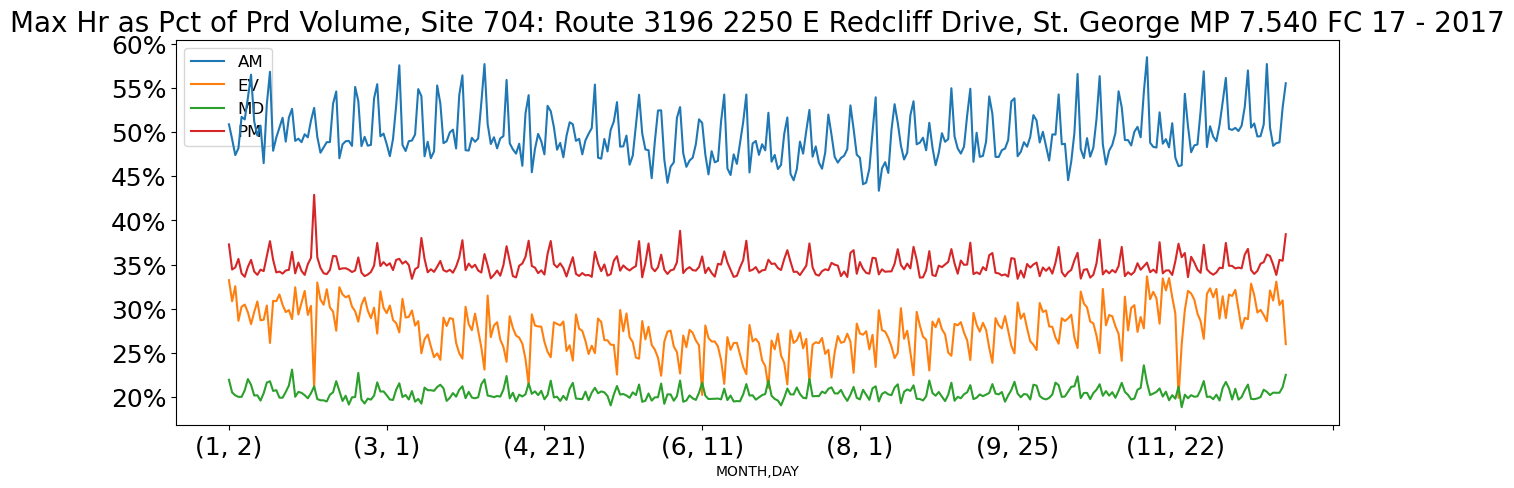

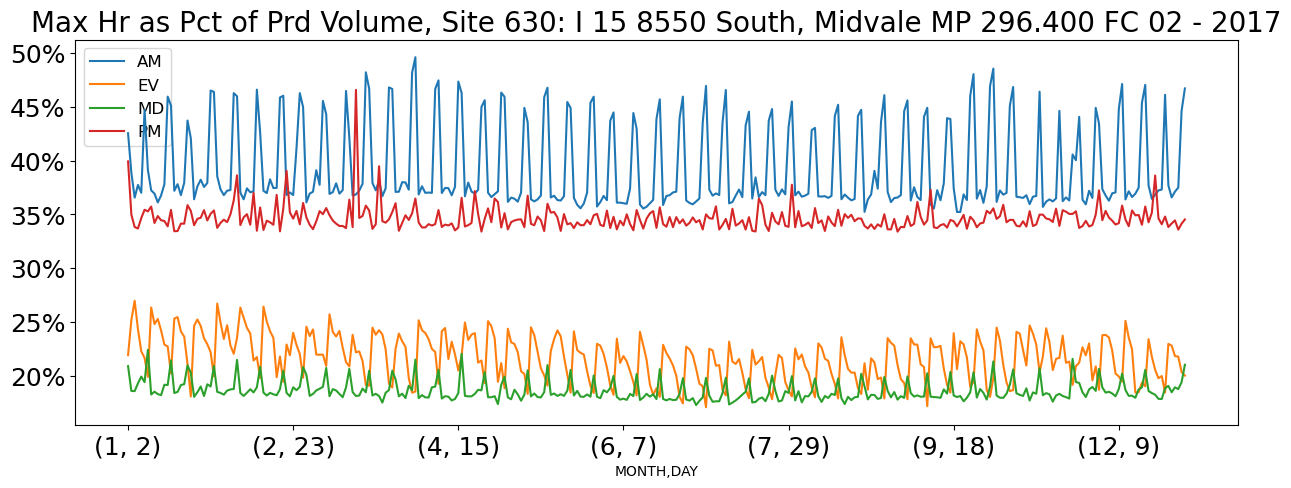

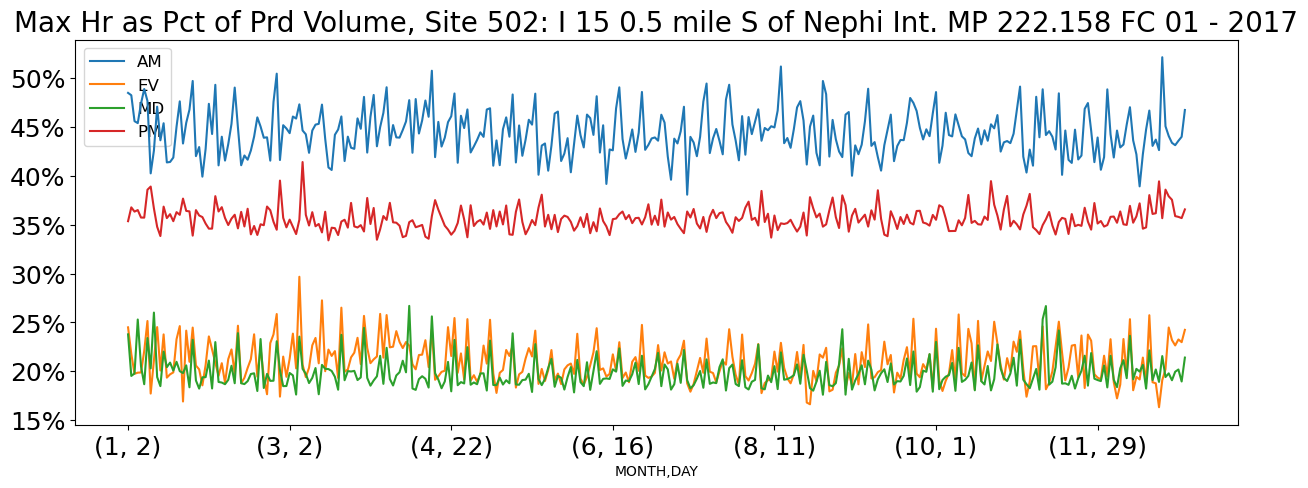

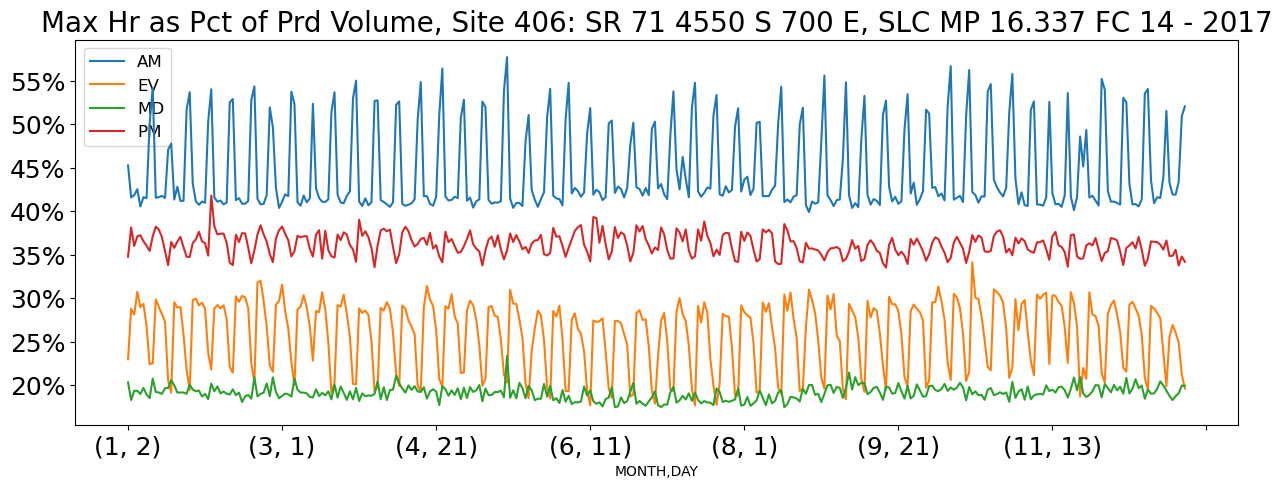

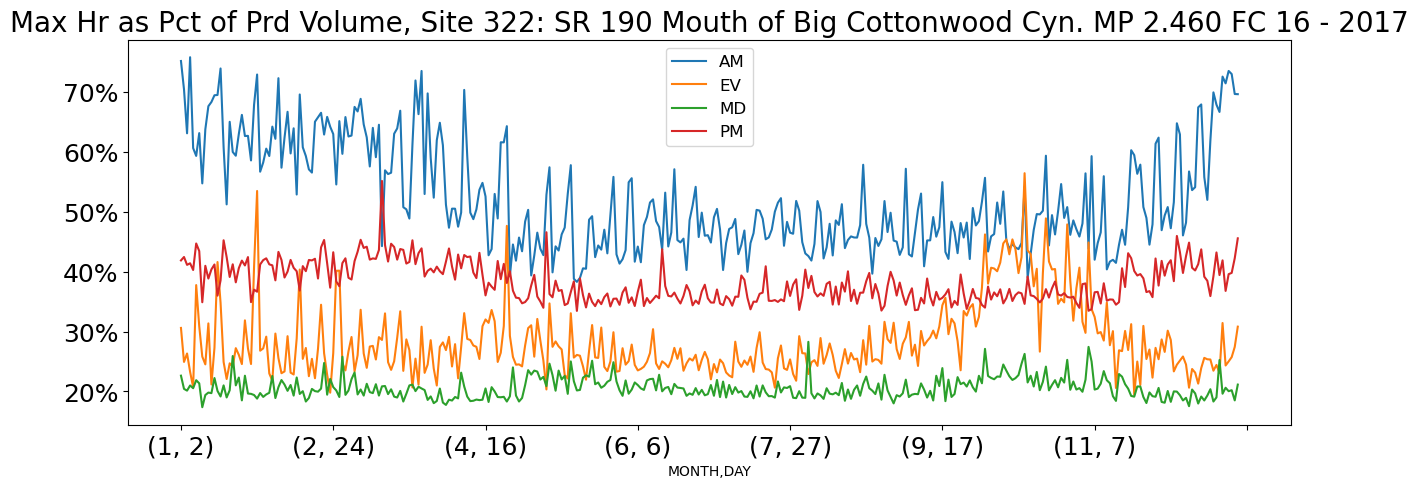

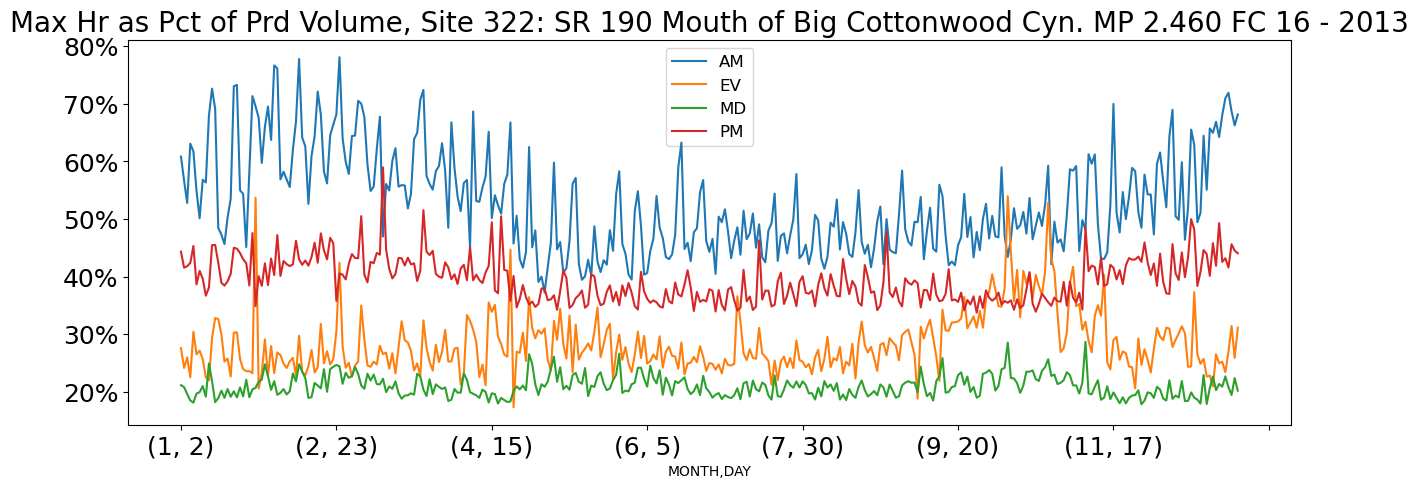

In [59]:
fnPlotSiteYear(704,2017)
fnPlotSiteYear(630,2017)
fnPlotSiteYear(502,2017)
fnPlotSiteYear(406,2017)
fnPlotSiteYear(322,2017)
fnPlotSiteYear(322,2013)

In [60]:
#prmDOWToDayGroups        
#prmMonthToSeasonGroups   
#prmYearToYearGroups      
#prmYearGroups            
#prmStationToStationGroups
#prmStationGroups         

#calculate month adt for each grouping

dfAllGroupPrdwDYVols = pd.DataFrame.merge(dfPrdVolwDY         ,prmDOWToDayGroups        ,on=(sDOWCol    ))
dfAllGroupPrdwDYVols = pd.DataFrame.merge(dfAllGroupPrdwDYVols,prmMonthToSeasonGroups   ,on=(sMonthCol  ))
dfAllGroupPrdwDYVols = pd.DataFrame.merge(dfAllGroupPrdwDYVols,prmYearToYearGroups      ,on=(sYearCol   ))
dfAllGroupPrdwDYVols = pd.DataFrame.merge(dfAllGroupPrdwDYVols,prmStationToStationGroups,on=(sStationCol))
display(dfAllGroupPrdwDYVols)

dfAllGroupPrdwDYVols = dfAllGroupPrdwDYVols.groupby([sStationGrpCol,sYearGrpCol,sSeasonGrpCol,sDOWGrpCol,'PERIOD'],as_index=False).agg(PERIODVOLSUM=('PERIODVOL','sum'),PKHRVOLSUM=('PKHRVOL','sum'),DAYVOLSUM=('DAYVOL','sum'))
display(dfAllGroupPrdwDYVols)

dfAllGroupPrdFactors = dfAllGroupPrdwDYVols.copy()
dfAllGroupPrdFactors['PKHRVOL_PCTDY'  ] = dfAllGroupPrdFactors['PKHRVOLSUM'  ] / dfAllGroupPrdFactors['DAYVOLSUM'   ]
dfAllGroupPrdFactors['PKHRVOL_PCTPRD' ] = dfAllGroupPrdFactors['PKHRVOLSUM'  ] / dfAllGroupPrdFactors['PERIODVOLSUM']
dfAllGroupPrdFactors['PERIODVOL_PCTDY'] = dfAllGroupPrdFactors['PERIODVOLSUM'] / dfAllGroupPrdFactors['DAYVOLSUM'   ]
dfAllGroupPrdFactors = dfAllGroupPrdFactors.drop(columns=(['PERIODVOLSUM','PKHRVOLSUM','DAYVOLSUM']))
display(dfAllGroupPrdFactors)

,STATION,YEAR,MONTH,DAY,DOW,DATE,PERIOD,PERIODVOL,PKHRVOL,DAYVOL,VOLPKHRPCTDY,VOLPKHRPCTPRD,DOWLABEL,DOWGROUP,SEASONGROUP,SGTYPE,YEARGROUP,STATIONGROUP
0,301.0,2013,1,2,2,2013-01-02,AM,8962,3795,48604,0.078080,0.423455,Wed,1-Weekday (Tu-Th),M01-Jan,Month,2013,301
1,301.0,2013,1,2,2,2013-01-02,AM,8962,3795,48604,0.078080,0.423455,Wed,1-Weekday (Tu-Th),M01-Jan,Month,2013,ALL
2,301.0,2013,1,2,2,2013-01-02,AM,8962,3795,48604,0.078080,0.423455,Wed,1-Weekday (Tu-Th),M01-Jan,Month,2013,COD
3,301.0,2013,1,2,2,2013-01-02,AM,8962,3795,48604,0.078080,0.423455,Wed,1-Weekday (Tu-Th),M01-Jan,Month,2013,SNA
4,301.0,2013,1,2,2,2013-01-02,AM,8962,3795,48604,0.078080,0.423455,Wed,1-Weekday (Tu-Th),M01-Jan,Month,2013,U50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121717912,702.0,2023,12,26,1,2023-12-26,PM,8399,2876,34914,0.082374,0.342422,Tue,D2-Tuesday,Year,Year,2023,ALL
121717913,702.0,2023,12,26,1,2023-12-26,PM,8399,2876,34914,0.082374,0.342422,Tue,D2-Tuesday,Year,Year,2019-2023,702
121717914,702.0,2023,12,26,1,2023-12-26,PM,8399,2876,34914,0.082374,0.342422,Tue,D2-Tuesday,Year,Year,2019-2023,ALL
121717915,702.0,2023,12,26,1,2023-12-26,PM,8399,2876,34914,0.082374,0.342422,Tue,D2-Tuesday,Year,Year,All Years,702


,STATIONGROUP,YEARGROUP,SEASONGROUP,DOWGROUP,PERIOD,PERIODVOLSUM,PKHRVOLSUM,DAYVOLSUM
0,301,2013,M01-Jan,1-Weekday (Tu-Th),AM,120755,50796,653452
1,301,2013,M01-Jan,1-Weekday (Tu-Th),EV,154645,40659,653452
2,301,2013,M01-Jan,1-Weekday (Tu-Th),MD,222874,41050,653452
3,301,2013,M01-Jan,1-Weekday (Tu-Th),PM,155178,58166,653452
4,301,2013,M01-Jan,2-Weekend (Sa-Su),AM,33175,14547,341552
...,...,...,...,...,...,...,...,...
1563627,WDK,All Years,Year,D6-Saturday,PM,1428721,497959,6200102
1563628,WDK,All Years,Year,D7-Sunday,AM,397570,171232,4582719
1563629,WDK,All Years,Year,D7-Sunday,EV,1211142,280379,4564031
1563630,WDK,All Years,Year,D7-Sunday,MD,1855822,368362,4582719


,STATIONGROUP,YEARGROUP,SEASONGROUP,DOWGROUP,PERIOD,PKHRVOL_PCTDY,PKHRVOL_PCTPRD,PERIODVOL_PCTDY
0,301,2013,M01-Jan,1-Weekday (Tu-Th),AM,0.077735,0.420653,0.184796
1,301,2013,M01-Jan,1-Weekday (Tu-Th),EV,0.062222,0.262918,0.236659
2,301,2013,M01-Jan,1-Weekday (Tu-Th),MD,0.062820,0.184185,0.341072
3,301,2013,M01-Jan,1-Weekday (Tu-Th),PM,0.089013,0.374834,0.237474
4,301,2013,M01-Jan,2-Weekend (Sa-Su),AM,0.042591,0.438493,0.097130
...,...,...,...,...,...,...,...,...
1563627,WDK,All Years,Year,D6-Saturday,PM,0.080315,0.348535,0.230435
1563628,WDK,All Years,Year,D7-Sunday,AM,0.037365,0.430696,0.086754
1563629,WDK,All Years,Year,D7-Sunday,EV,0.061432,0.231500,0.265367
1563630,WDK,All Years,Year,D7-Sunday,MD,0.080381,0.198490,0.404961


In [61]:
#COT,COT: Combined Statewide Arterial - Suburban,COFACGEO,1
display(dfAllGroupPrdFactors[dfAllGroupPrdFactors['STATIONGROUP']=='COT'])

,STATIONGROUP,YEARGROUP,SEASONGROUP,DOWGROUP,PERIOD,PKHRVOL_PCTDY,PKHRVOL_PCTPRD,PERIODVOL_PCTDY
1014668,COT,2013,M01-Jan,1-Weekday (Tu-Th),AM,0.072897,0.412907,0.176545
1014669,COT,2013,M01-Jan,1-Weekday (Tu-Th),EV,0.069266,0.278778,0.248464
1014670,COT,2013,M01-Jan,1-Weekday (Tu-Th),MD,0.062655,0.194992,0.321319
1014671,COT,2013,M01-Jan,1-Weekday (Tu-Th),PM,0.096579,0.380726,0.253672
1014672,COT,2013,M01-Jan,2-Weekend (Sa-Su),AM,0.035343,0.480907,0.073493
...,...,...,...,...,...,...,...,...
1023231,COT,All Years,Year,D6-Saturday,PM,0.076264,0.347772,0.219291
1023232,COT,All Years,Year,D7-Sunday,AM,0.031103,0.462924,0.067187
1023233,COT,All Years,Year,D7-Sunday,EV,0.070485,0.216099,0.326169
1023234,COT,All Years,Year,D7-Sunday,MD,0.076236,0.209333,0.364187


In [62]:
dfAllGroupPrdFactors_Derived = pd.DataFrame.merge(prmDerivedStationPortions,dfAllGroupPrdFactors,left_on=sStationGrpCol + 'DERIVEDFROM',right_on=sStationGrpCol)
dfAllGroupPrdFactors_Derived['PKHRVOL_PCTDY_NEW'  ] = dfAllGroupPrdFactors_Derived['PORTION'] * dfAllGroupPrdFactors_Derived['PKHRVOL_PCTDY'  ]
dfAllGroupPrdFactors_Derived['PKHRVOL_PCTPRD_NEW' ] = dfAllGroupPrdFactors_Derived['PORTION'] * dfAllGroupPrdFactors_Derived['PKHRVOL_PCTPRD' ]
dfAllGroupPrdFactors_Derived['PERIODVOL_PCTDY_NEW'] = dfAllGroupPrdFactors_Derived['PORTION'] * dfAllGroupPrdFactors_Derived['PERIODVOL_PCTDY']
dfAllGroupPrdFactors_Derived = dfAllGroupPrdFactors_Derived.rename(columns={sStationGrpCol+'_x':sStationGrpCol})
dfAllGroupPrdFactors_Derived = dfAllGroupPrdFactors_Derived.groupby([sStationGrpCol,sSeasonGrpCol,sYearGrpCol,sDOWGrpCol,'PERIOD'],as_index=False).agg(PKHRVOL_PCTDY=('PKHRVOL_PCTDY_NEW','sum'),PKHRVOL_PCTPRD=('PKHRVOL_PCTPRD_NEW','sum'),PERIODVOL_PCTDY=('PERIODVOL_PCTDY_NEW','sum'),RECORDCNT=('PKHRVOL_PCTDY','size'))
display(dfAllGroupPrdFactors_Derived)
dfAllGroupPrdFactors_Derived = dfAllGroupPrdFactors_Derived.drop(columns=(['RECORDCNT']))
display(dfAllGroupPrdFactors_Derived)

,STATIONGROUP,SEASONGROUP,YEARGROUP,DOWGROUP,PERIOD,PKHRVOL_PCTDY,PKHRVOL_PCTPRD,PERIODVOL_PCTDY,RECORDCNT
0,SNB,M01-Jan,2013,1-Weekday (Tu-Th),AM,0.074207,0.399312,0.185853,2
1,SNB,M01-Jan,2013,1-Weekday (Tu-Th),EV,0.059644,0.237608,0.251269,2
2,SNB,M01-Jan,2013,1-Weekday (Tu-Th),MD,0.061317,0.188512,0.325265,2
3,SNB,M01-Jan,2013,1-Weekday (Tu-Th),PM,0.088235,0.371328,0.237612,2
4,SNB,M01-Jan,2013,2-Weekend (Sa-Su),AM,0.040430,0.425274,0.095110,2
...,...,...,...,...,...,...,...,...,...
45895,XX4,Year,All Years,D6-Saturday,PM,0.075442,0.347985,0.216658,3
45896,XX4,Year,All Years,D7-Sunday,AM,0.031464,0.405656,0.077590,3
45897,XX4,Year,All Years,D7-Sunday,EV,0.066079,0.197862,0.334176,3
45898,XX4,Year,All Years,D7-Sunday,MD,0.074253,0.208991,0.355513,3


,STATIONGROUP,SEASONGROUP,YEARGROUP,DOWGROUP,PERIOD,PKHRVOL_PCTDY,PKHRVOL_PCTPRD,PERIODVOL_PCTDY
0,SNB,M01-Jan,2013,1-Weekday (Tu-Th),AM,0.074207,0.399312,0.185853
1,SNB,M01-Jan,2013,1-Weekday (Tu-Th),EV,0.059644,0.237608,0.251269
2,SNB,M01-Jan,2013,1-Weekday (Tu-Th),MD,0.061317,0.188512,0.325265
3,SNB,M01-Jan,2013,1-Weekday (Tu-Th),PM,0.088235,0.371328,0.237612
4,SNB,M01-Jan,2013,2-Weekend (Sa-Su),AM,0.040430,0.425274,0.095110
...,...,...,...,...,...,...,...,...
45895,XX4,Year,All Years,D6-Saturday,PM,0.075442,0.347985,0.216658
45896,XX4,Year,All Years,D7-Sunday,AM,0.031464,0.405656,0.077590
45897,XX4,Year,All Years,D7-Sunday,EV,0.066079,0.197862,0.334176
45898,XX4,Year,All Years,D7-Sunday,MD,0.074253,0.208991,0.355513


In [64]:
dfAllGroupPrdFactors = pd.concat([dfAllGroupPrdFactors, dfAllGroupPrdFactors_Derived], ignore_index=True)
dfAllGroupPrdFactors

,STATIONGROUP,YEARGROUP,SEASONGROUP,DOWGROUP,PERIOD,PKHRVOL_PCTDY,PKHRVOL_PCTPRD,PERIODVOL_PCTDY
0,301,2013,M01-Jan,1-Weekday (Tu-Th),AM,0.077735,0.420653,0.184796
1,301,2013,M01-Jan,1-Weekday (Tu-Th),EV,0.062222,0.262918,0.236659
2,301,2013,M01-Jan,1-Weekday (Tu-Th),MD,0.062820,0.184185,0.341072
3,301,2013,M01-Jan,1-Weekday (Tu-Th),PM,0.089013,0.374834,0.237474
4,301,2013,M01-Jan,2-Weekend (Sa-Su),AM,0.042591,0.438493,0.097130
...,...,...,...,...,...,...,...,...
1609527,XX4,All Years,Year,D6-Saturday,PM,0.075442,0.347985,0.216658
1609528,XX4,All Years,Year,D7-Sunday,AM,0.031464,0.405656,0.077590
1609529,XX4,All Years,Year,D7-Sunday,EV,0.066079,0.197862,0.334176
1609530,XX4,All Years,Year,D7-Sunday,MD,0.074253,0.208991,0.355513


In [65]:
dfAllGroupPrdFactors.to_csv(csv_factors_period,index=False)

# Combine Factors (except for Time-of-Day) into single table

In [66]:
display(dfSeasonFactors)
display(dfMaxMonthFactorMax)
display(dfMaxMonthFactorMo)
display(dfSeasonGroupDOWFactors_toCombine)
display(dfSeasonGroupDOWFactorsMinMax_toCombine)

,STATIONGROUP,SEASONGROUP,YEARGROUP,FACTORNAME,FACTOR
0,301,M01-Jan,2013,FAC_JAN,0.905472
1,301,M01-Jan,2013-2017,FAC_JAN,0.952858
2,301,M01-Jan,2014,FAC_JAN,0.985614
3,301,M01-Jan,2015,FAC_JAN,0.939451
4,301,M01-Jan,2015-2019,FAC_JAN,0.958303
...,...,...,...,...,...
43430,WDK,Year,2016,FAC_YR,1.000000
43431,WDK,Year,2018,FAC_YR,1.000000
43432,WDK,Year,2019,FAC_YR,1.000000
43433,WDK,Year,2019-2023,FAC_YR,1.000000


,STATIONGROUP,SEASONGROUP,YEARGROUP,FACTORNAME,FACTOR
0,301,Year,2013,FAC_MAX,1.247890
1,301,Year,2013-2017,FAC_MAX,1.185596
2,301,Year,2014,FAC_MAX,1.162994
3,301,Year,2015,FAC_MAX,1.184390
4,301,Year,2015-2019,FAC_MAX,1.180784
...,...,...,...,...,...
2550,WDK,Year,2016,FAC_MAX,1.165954
2551,WDK,Year,2018,FAC_MAX,1.183243
2552,WDK,Year,2019,FAC_MAX,1.216987
2553,WDK,Year,2019-2023,FAC_MAX,1.216987


,STATIONGROUP,SEASONGROUP,YEARGROUP,FACTORNAME,FACTOR
0,317,Year,2019,FAC_MAXMO,1
1,317,Year,2019-2023,FAC_MAXMO,1
2,317,Year,2020,FAC_MAXMO,1
3,322,Year,2023,FAC_MAXMO,1
4,605,Year,2013,FAC_MAXMO,1
...,...,...,...,...,...
2550,704,Year,All Years,FAC_MAXMO,12
2551,COV,Year,2018,FAC_MAXMO,12
2552,SNV,Year,2018,FAC_MAXMO,12
2553,U70,Year,2018,FAC_MAXMO,12


,STATIONGROUP,SEASONGROUP,YEARGROUP,FACTORNAME,FACTOR
0,301,M01-Jan,2013,FAC_WDAVG,1.037302
1,301,M01-Jan,2013-2017,FAC_WDAVG,1.019329
2,301,M01-Jan,2014,FAC_WDAVG,0.999186
3,301,M01-Jan,2015,FAC_WDAVG,1.028996
4,301,M01-Jan,2015-2019,FAC_WDAVG,1.025656
...,...,...,...,...,...
390910,WDK,Year,2016,FAC_SUN,0.765462
390911,WDK,Year,2018,FAC_SUN,0.764525
390912,WDK,Year,2019,FAC_SUN,0.764131
390913,WDK,Year,2019-2023,FAC_SUN,0.764131


,STATIONGROUP,SEASONGROUP,YEARGROUP,FACTORNAME,FACTOR
0,301,M01-Jan,2013,FAC_WEMAX,1.071602
1,301,M01-Jan,2013-2017,FAC_WEMAX,1.044259
2,301,M01-Jan,2014,FAC_WEMAX,1.120029
3,301,M01-Jan,2015,FAC_WEMAX,1.043339
4,301,M01-Jan,2015-2019,FAC_WEMAX,0.990147
...,...,...,...,...,...
43430,WDK,Year,2016,FAC_WEMAX,1.027354
43431,WDK,Year,2018,FAC_WEMAX,1.005870
43432,WDK,Year,2019,FAC_WEMAX,1.010885
43433,WDK,Year,2019-2023,FAC_WEMAX,1.010885


In [68]:
dfFactors_Base = dfSeasonFactors[0:0] #just copy data structure, no row data

dfFactors_Base = pd.concat(
    [
        dfFactors_Base,
        dfSeasonFactors,
        dfMaxMonthFactorMo,
        dfMaxMonthFactorMax,
        dfSeasonGroupDOWFactors_toCombine,
        dfSeasonGroupDOWFactorsMinMax_toCombine
    ],
    ignore_index=True
)

dfFactors_Base

,STATIONGROUP,SEASONGROUP,YEARGROUP,FACTORNAME,FACTOR
0,301,M01-Jan,2013,FAC_JAN,0.905472
1,301,M01-Jan,2013-2017,FAC_JAN,0.952858
2,301,M01-Jan,2014,FAC_JAN,0.985614
3,301,M01-Jan,2015,FAC_JAN,0.939451
4,301,M01-Jan,2015-2019,FAC_JAN,0.958303
...,...,...,...,...,...
482890,WDK,Year,2016,FAC_WEMAX,1.027354
482891,WDK,Year,2018,FAC_WEMAX,1.005870
482892,WDK,Year,2019,FAC_WEMAX,1.010885
482893,WDK,Year,2019-2023,FAC_WEMAX,1.010885


# Add Derived Station Groups

In [69]:
dfFactors_Derived = pd.DataFrame.merge(prmDerivedStationPortions,dfFactors_Base,left_on=sStationGrpCol + 'DERIVEDFROM',right_on=sStationGrpCol)
dfFactors_Derived['FACTOR_NEW'] = dfFactors_Derived['PORTION'] * dfFactors_Derived['FACTOR']
dfFactors_Derived = dfFactors_Derived.rename(columns={sStationGrpCol+'_x':sStationGrpCol})
dfFactors_Derived = dfFactors_Derived.groupby([sStationGrpCol,sSeasonGrpCol,sYearGrpCol,'FACTORNAME'],as_index=False).agg(FACTOR=('FACTOR_NEW','sum'),RECORDCNT=('FACTOR_NEW','size'))
display(dfFactors_Derived)
dfFactors_Derived = dfFactors_Derived[[sStationGrpCol,sSeasonGrpCol,sYearGrpCol,'FACTORNAME','FACTOR']]
display(dfFactors_Derived)

,STATIONGROUP,SEASONGROUP,YEARGROUP,FACTORNAME,FACTOR,RECORDCNT
0,SNB,M01-Jan,2013,FAC_FRI,1.092775,2
1,SNB,M01-Jan,2013,FAC_JAN,0.865805,2
2,SNB,M01-Jan,2013,FAC_MON,0.999166,2
3,SNB,M01-Jan,2013,FAC_SAT,0.965680,2
4,SNB,M01-Jan,2013,FAC_SUN,0.738281,2
...,...,...,...,...,...,...
14170,XX4,Year,All Years,FAC_WDAVG,1.156767,3
14171,XX4,Year,All Years,FAC_WEAVG,0.630644,3
14172,XX4,Year,All Years,FAC_WED,1.159393,3
14173,XX4,Year,All Years,FAC_WEMAX,0.733765,3


,STATIONGROUP,SEASONGROUP,YEARGROUP,FACTORNAME,FACTOR
0,SNB,M01-Jan,2013,FAC_FRI,1.092775
1,SNB,M01-Jan,2013,FAC_JAN,0.865805
2,SNB,M01-Jan,2013,FAC_MON,0.999166
3,SNB,M01-Jan,2013,FAC_SAT,0.965680
4,SNB,M01-Jan,2013,FAC_SUN,0.738281
...,...,...,...,...,...
14170,XX4,Year,All Years,FAC_WDAVG,1.156767
14171,XX4,Year,All Years,FAC_WEAVG,0.630644
14172,XX4,Year,All Years,FAC_WED,1.159393
14173,XX4,Year,All Years,FAC_WEMAX,0.733765


In [71]:
dfFactors = pd.concat([dfFactors_Base, dfFactors_Derived], ignore_index=True)
dfFactors

,STATIONGROUP,SEASONGROUP,YEARGROUP,FACTORNAME,FACTOR
0,301,M01-Jan,2013,FAC_JAN,0.905472
1,301,M01-Jan,2013-2017,FAC_JAN,0.952858
2,301,M01-Jan,2014,FAC_JAN,0.985614
3,301,M01-Jan,2015,FAC_JAN,0.939451
4,301,M01-Jan,2015-2019,FAC_JAN,0.958303
...,...,...,...,...,...
497065,XX4,Year,All Years,FAC_WDAVG,1.156767
497066,XX4,Year,All Years,FAC_WEAVG,0.630644
497067,XX4,Year,All Years,FAC_WED,1.159393
497068,XX4,Year,All Years,FAC_WEMAX,0.733765


In [72]:
#check to see if all stations are there
dfFactors[sStationGrpCol].unique()

array(['301', '302', '303', '304', '305', '306', '307', '308', '309',
       '310', '312', '313', '314', '315', '316', '317', '318', '319',
       '320', '321', '322', '323', '324', '325', '327', '329', '332',
       '333', '335', '340', '341', '348', '349', '350', '351', '353',
       '354', '355', '362', '363', '382', '400', '401', '402', '403',
       '404', '405', '406', '407', '408', '409', '411', '412', '414',
       '415', '416', '418', '420', '421', '424', '425', '427', '430',
       '431', '501', '502', '503', '504', '506', '507', '508', '509',
       '510', '511', '512', '513', '601', '602', '605', '606', '609',
       '611', '612', '613', '614', '615', '616', '617', '619', '620',
       '621', '622', '623', '624', '625', '626', '627', '628', '629',
       '630', '631', '632', '633', '634', '635', '636', '638', '639',
       '648', '649', '655', '660', '661', '665', '667', '669', '671',
       '672', '674', '702', '703', '704', '711', '712', '713', '714',
       '715', 'ALL',

In [73]:
dfFactors.to_csv(csv_factors,index=False)

# Create Web App Data

In [74]:
#export DOW factors for web app

dfDOWForWebApp = pd.DataFrame.merge(dfFactors,prmWebAppDOWGroups,left_on=('FACTORNAME'),right_on=(sDOWFieldName))
dfDOWForWebApp = dfDOWForWebApp[dfDOWForWebApp['DAYGROUP']==1]
dfDOWForWebApp = dfDOWForWebApp[[sStationGrpCol,sYearGrpCol,sSeasonGrpCol,'DAYNAME','FACTOR']]
dfDOWForWebApp = dfDOWForWebApp.rename(columns={sStationGrpCol:'SG',sYearGrpCol:'YG','SEASONGROUP':'MG','DAYNAME':'D','FACTOR':'F'})
dfDOWForWebApp['F'] = dfDOWForWebApp['F'].astype(str).str[:6]
#dfDOWForWebApp = dfDOWForWebApp[-dfDOWForWebApp.SG.str[0].str.isalpha()] #station group starts with numeric character
dfDOWForWebApp.to_json(json_dowfactors,orient='records')
dfDOWForWebApp

,SG,YG,MG,D,F
89420,301,2013,M01-Jan,Mon,0.9192
89421,301,2013-2017,M01-Jan,Mon,0.9501
89422,301,2014,M01-Jan,Mon,0.9411
89423,301,2015,M01-Jan,Mon,0.9310
89424,301,2015-2019,M01-Jan,Mon,0.9715
...,...,...,...,...,...
402385,XX4,2018,Year,Sun,0.5211
402386,XX4,2019,Year,Sun,0.5396
402387,XX4,2019-2023,Year,Sun,0.5463
402388,XX4,2023,Year,Sun,0.2090


In [75]:
#export DOW factors for web app

dfDOWForWebApp_StationGroup = pd.DataFrame.merge(dfFactors,prmWebAppDOWGroups,left_on=('FACTORNAME'),right_on=(sDOWFieldName))
dfDOWForWebApp_StationGroup = dfDOWForWebApp_StationGroup[dfDOWForWebApp_StationGroup['DAYGROUP']==2]
dfDOWForWebApp_StationGroup = dfDOWForWebApp_StationGroup[[sStationGrpCol,sYearGrpCol,sSeasonGrpCol,'DAYNAME','FACTOR']]
dfDOWForWebApp_StationGroup = dfDOWForWebApp_StationGroup.rename(columns={sStationGrpCol:'SG',sYearGrpCol:'YG','SEASONGROUP':'MG','DAYNAME':'D','FACTOR':'F'})
dfDOWForWebApp_StationGroup['F'] = dfDOWForWebApp_StationGroup['F'].astype(str).str[:6]
dfDOWForWebApp_StationGroup = dfDOWForWebApp_StationGroup[dfDOWForWebApp_StationGroup.SG.str[0].str.isalpha()] #station group starts with alpha character
dfDOWForWebApp_StationGroup.to_json(json_wdfactors,orient='records')
dfDOWForWebApp_StationGroup

,SG,YG,MG,D,F
22049,ALL,2013,M01-Jan,W1-Tue-Thu,1.0917
22050,ALL,2013-2017,M01-Jan,W1-Tue-Thu,1.0854
22051,ALL,2014,M01-Jan,W1-Tue-Thu,1.0685
22052,ALL,2015,M01-Jan,W1-Tue-Thu,1.0822
22053,ALL,2015-2019,M01-Jan,W1-Tue-Thu,1.0871
...,...,...,...,...,...
447095,XX4,2018,Year,MaxWkEnd,0.7232
447096,XX4,2019,Year,MaxWkEnd,0.7347
447097,XX4,2019-2023,Year,MaxWkEnd,0.7453
447098,XX4,2023,Year,MaxWkEnd,0.2857


In [76]:
dfDOWForWebApp_StationGroup

,SG,YG,MG,D,F
22049,ALL,2013,M01-Jan,W1-Tue-Thu,1.0917
22050,ALL,2013-2017,M01-Jan,W1-Tue-Thu,1.0854
22051,ALL,2014,M01-Jan,W1-Tue-Thu,1.0685
22052,ALL,2015,M01-Jan,W1-Tue-Thu,1.0822
22053,ALL,2015-2019,M01-Jan,W1-Tue-Thu,1.0871
...,...,...,...,...,...
447095,XX4,2018,Year,MaxWkEnd,0.7232
447096,XX4,2019,Year,MaxWkEnd,0.7347
447097,XX4,2019-2023,Year,MaxWkEnd,0.7453
447098,XX4,2023,Year,MaxWkEnd,0.2857


In [77]:
display(prmStationGroups)
#only use if first character of STATIONGROUP is alpha not numeric
dfStationForWebApp = prmStationGroups[prmStationGroups.STATIONGROUP.str[0].str.isalpha()]
dfStationForWebApp = dfStationForWebApp.rename(columns={sStationGrpCol:'value','STATIONGROUPDESCRIPTION':'label'})
dfStationForWebApp

,STATIONGROUP,STATIONGROUPDESCRIPTION,FACGEOGROUP,FINALCUT
0,301,"301: I 80 1 mile E of I 215 Int., Parleys Cany...",NaN,0
1,302,302: I 15 12900 South M.P. 290.600 FC 02,NaN,0
2,303,"303: SR 91 1.5 miles N of SR 61, Webster Jct M...",NaN,0
3,304,"304: SR 89 0.6 mile N of SR 30, Garden City MP...",NaN,0
4,305,"305: SR 24 0.1 mile N of SR 118, Sigurd MP 8.0...",NaN,0
...,...,...,...,...
279,WDH,WDH: Weekday Freeway I-84 West,WDFACGEO,0
280,WDI,WDI: Weekday Freeway Legacy,WDFACGEO,0
281,WDJ,WDJ: Weekday Freeway SR-201,WDFACGEO,0
282,WDK,WDK: Weekday Freeway US-40,WDFACGEO,0


,value,label,FACGEOGROUP,FINALCUT
175,ALL,All: All Stations in Utah,NaN,0
176,GRP,GRP: All Station Groups in Utah,NaN,0
177,CO0,CO0: Combined Alpine Loop,COFACGEO,1
178,CO1,CO1: Combined Bear Lake,COFACGEO,1
179,CO2,CO2: Combined Big Cottonwood,COFACGEO,1
...,...,...,...,...
279,WDH,WDH: Weekday Freeway I-84 West,WDFACGEO,0
280,WDI,WDI: Weekday Freeway Legacy,WDFACGEO,0
281,WDJ,WDJ: Weekday Freeway SR-201,WDFACGEO,0
282,WDK,WDK: Weekday Freeway US-40,WDFACGEO,0


In [78]:
dfStationForWebApp[dfStationForWebApp['value']=='COI']

,value,label,FACGEOGROUP,FINALCUT
197,COI,COI: Combined Little Cottonwood / Snowbasin,COFACGEO,1


In [79]:
dfStationForWebApp.to_json(json_stationgroups,orient='records')

dfStationForWebApp_finalcut = dfStationForWebApp[dfStationForWebApp['FINALCUT']==1]

#cutoff after CXX: Combined
dfStationForWebApp_finalcut['label'] = dfStationForWebApp_finalcut['label'].str[14:] + " (" + dfStationForWebApp_finalcut['value'] + ")"

dfStationForWebApp_finalcut.to_json(json_stationgroups_finalcut,orient='records')

dfStationForWebApp_finalcut

C:\Users\jlillywhite\AppData\Local\Temp\ipykernel_42300\3133081667.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfStationForWebApp_finalcut['label'] = dfStationForWebApp_finalcut['label'].str[14:] + " (" + dfStationForWebApp_finalcut['value'] + ")"


,value,label,FACGEOGROUP,FINALCUT
177,CO0,Alpine Loop (CO0),COFACGEO,1
178,CO1,Bear Lake (CO1),COFACGEO,1
179,CO2,Big Cottonwood (CO2),COFACGEO,1
180,CO3,Cedar Breaks (CO3),COFACGEO,1
181,CO7,Freeway I-15 Plymouth (CO7),COFACGEO,1
...,...,...,...,...
209,COU,Statewide Arterial - Urban/CBD (COU),COFACGEO,1
210,XX3,Statewide Freeway (XX3),COFACGEO,1
211,COV,Washington County Arterial (COV),COFACGEO,1
212,COW,Washington County Expressway (COW),COFACGEO,1


In [80]:
#year groups
dfYearGroups = prmYearGroups
dfYearGroups['value'] = dfYearGroups['YEARGROUP']
dfYearGroups['label'] = dfYearGroups['YEARGROUP']
dfYearGroups = dfYearGroups[['value','label']]
dfYearGroups.to_json(json_yeargroups,orient='records')
dfYearGroups

,value,label
0,2013,2013
1,2014,2014
2,2015,2015
3,2016,2016
4,2017,2017
...,...,...
10,2023,2023
11,2013-2017,2013-2017
12,2015-2019,2015-2019
13,2019-2023,2019-2023


In [81]:
#season factors
dfSeasonForWebApp = pd.DataFrame.merge(dfFactors,prmWebAppSeasonGroups,left_on=('FACTORNAME'),right_on=(sSGFieldName))
dfSeasonForWebApp = dfSeasonForWebApp[dfSeasonForWebApp['GROUP']==1]
dfSeasonForWebApp = dfSeasonForWebApp[[sStationGrpCol,sYearGrpCol,'NAME','FACTOR']]
dfSeasonForWebApp = dfSeasonForWebApp.rename(columns={sStationGrpCol:'SG',sYearGrpCol:'YG','NAME':'M','FACTOR':'F'})
dfSeasonForWebApp['F'] = dfSeasonForWebApp['F'].astype(str).str[:6]
dfSeasonForWebApp.to_json(json_monthfactors,orient='records')
dfSeasonForWebApp

,SG,YG,M,F
0,301,2013,Jan,0.9054
1,301,2013-2017,Jan,0.9528
2,301,2014,Jan,0.9856
3,301,2015,Jan,0.9394
4,301,2015-2019,Jan,0.9583
...,...,...,...,...
31555,XX4,2018,Dec,0.9844
31556,XX4,2019,Dec,0.9093
31557,XX4,2019-2023,Dec,0.9141
31558,XX4,2023,Dec,0.3343


In [82]:
#export DOW factors for web app

dfSeasonForWebApp_StationGroup = pd.DataFrame.merge(dfFactors,prmWebAppSeasonGroups,left_on=('FACTORNAME'),right_on=(sSGFieldName))
dfSeasonForWebApp_StationGroup = dfSeasonForWebApp_StationGroup[dfSeasonForWebApp_StationGroup['GROUP']==2]
dfSeasonForWebApp_StationGroup = dfSeasonForWebApp_StationGroup[[sStationGrpCol,sYearGrpCol,'NAME','FACTOR']]
dfSeasonForWebApp_StationGroup = dfSeasonForWebApp_StationGroup.rename(columns={sStationGrpCol:'SG',sYearGrpCol:'YG','NAME':'M','FACTOR':'F'})
dfSeasonForWebApp_StationGroup['F'] = dfSeasonForWebApp_StationGroup['F'].astype(str).str[:6]
dfSeasonForWebApp_StationGroup = dfSeasonForWebApp_StationGroup[dfSeasonForWebApp_StationGroup.SG.str[0].str.isalpha()] #station group starts with alpha character
dfSeasonForWebApp_StationGroup.to_json(json_seasonfactors,orient='records')
dfSeasonForWebApp_StationGroup

,SG,YG,M,F
32857,ALL,2013,Winter,0.9141
32858,ALL,2013-2017,Winter,0.9298
32859,ALL,2014,Winter,0.9307
32860,ALL,2015,Winter,0.9380
32861,ALL,2015-2019,Winter,0.9337
...,...,...,...,...
42075,XX4,2018,Fall,1.0230
42076,XX4,2019,Fall,1.0250
42077,XX4,2019-2023,Fall,1.0244
42078,XX4,2023,Fall,0.3395


In [83]:
# station groups

dfStationsFromStationGroups = prmStationGroups[-prmStationGroups.STATIONGROUP.str[0].str.isalpha()].copy()
dfStationsFromStationGroups = dfStationsFromStationGroups.rename(columns={'STATIONGROUP':'StationID','STATIONGROUPDESCRIPTION':'StationName'})
dfStationsFromStationGroups['StationID'] = dfStationsFromStationGroups['StationID'].astype('int64')
dfStationsFromStationGroups

#prmStationToStationGroups
dfStationGroupsNoSingleStations = prmStationToStationGroups[prmStationToStationGroups.STATIONGROUP.str[0].str.isalpha()].copy()
dfStationGroupsNoSingleStations = dfStationGroupsNoSingleStations.rename(columns={'STATION':'StationID','STATIONGROUP':'StationGroup'})
dfStationGroupsNoSingleStations

dfStationGroupsCCS = pd.DataFrame.merge(dfStationsFromStationGroups,dfStationGroupsNoSingleStations,on='StationID')
dfStationGroupsCCS = dfStationGroupsCCS[['StationGroup','StationID','StationName']]
dfStationGroupsCCS = dfStationGroupsCCS.sort_values(by=['StationGroup','StationID'])
dfStationGroupsCCS

,StationGroup,StationID,StationName
0,ALL,301,"301: I 80 1 mile E of I 215 Int., Parleys Cany..."
5,ALL,302,302: I 15 12900 South M.P. 290.600 FC 02
10,ALL,303,"303: SR 91 1.5 miles N of SR 61, Webster Jct M..."
15,ALL,304,"304: SR 89 0.6 mile N of SR 30, Garden City MP..."
21,ALL,305,"305: SR 24 0.1 mile N of SR 118, Sigurd MP 8.0..."
...,...,...,...
434,WDH,614,614: I 84 3.2 miles W of Bothwell Int. MP 36.6...
479,WDI,624,624: SR 67 Legacy Parkway MP 0.944 FC 12
484,WDI,625,625: SR 67 Legacy Parkway MP 11.418 FC 12
454,WDJ,619,"619: SR 201 6174 W, SLC MP 10.600 FC 12"
